# Влияние изменения шрифта в приложения на продажи.

Наша задача разобраться, как ведут себя пользователи при изменении шрифта в приложении. Мы проведем анали имеющихся данных и проведем А/А/В тестирование.

#### Данное исследование разделим на несколько частей.


##### * [1. Изученеие файлов с данными, получение общей информации, загрузка библиотек, подготовка данных](#1-bullet)
##### * [2. Предобработка данных.](#2-bullet)
##### * [3.Изучение и проверка данных.](#3-bullet)
##### * [4. Изучение воронки событий.](#4-bullet)
##### * [5. A/A/B-тестирование. Изучение результатов эксперимента.](#5-bullet)
##### * [6. Общий вывод.](#6-bullet)

<a id='1-bullet'></a>

### Изучение общей информации о таблице

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as dt
from scipy import stats as st
import numpy as np
import math as mth
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t' )
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### Вывод:

Итак, нам дана таблица с 4 столбцами 244126 строками без пропусков. В данный момент для удобства мы исправим название столбцов и переведем тип данных во временной. Посмотрим есть ли дубликаты и удалим их.

<a id='2-bullet'></a>

## Предобработка данных

In [5]:
df=df.rename(columns={'EventName': 'event' ,'DeviceIDHash': 'id', 'EventTimestamp': 'time', 'ExpId': 'exp_id' })

In [6]:
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 413


In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df['time']=pd.to_datetime(df['time'], unit='s')

In [9]:
df['date_time']=df['time'].dt.date

### Вывод:

Теперь у нас имеется приятная для анализа таблица с дополнительным столбцом.

<a id='3-bullet'></a>

## Изучение и проверка данных

In [10]:
print('Количество событий:',df.groupby('event')['id'].count())
print(' ')
print('Всего событий:', df['event'].count())

Количество событий: event
CartScreenAppear            42668
MainScreenAppear           119101
OffersScreenAppear          46808
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: id, dtype: int64
 
Всего событий: 243713


In [11]:
print('Количество пользователей:',df['id'].nunique())
polisov_1=df['id'].nunique()
polisov_2=df['event'].count()
print('Среднее количество событий на пользователя', int(df['event'].count()/df['id'].nunique()))

Количество пользователей: 7551
Среднее количество событий на пользователя 32


Мы нашли некотые первичные данные.

In [12]:
print('Минимальная дата:',df['time'].min())
print('Максимальная дата:', df['time'].max())

Минимальная дата: 2019-07-25 04:43:36
Максимальная дата: 2019-08-07 21:15:17


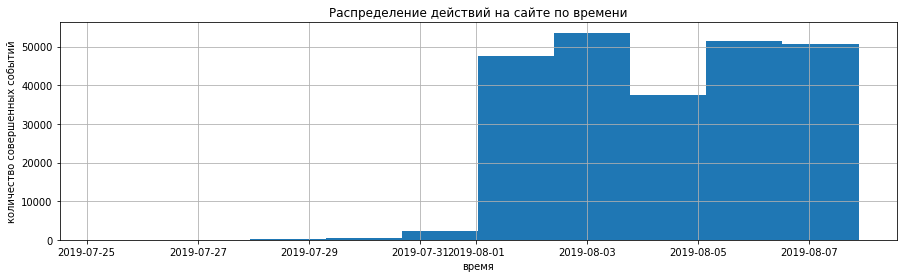

In [13]:
plt.figure(figsize=(15, 4))
df['time'].hist()
plt.title('Распределение действий на сайте по времени')
plt.xlabel("время")
plt.ylabel("количество совершенных событий")
plt.show()

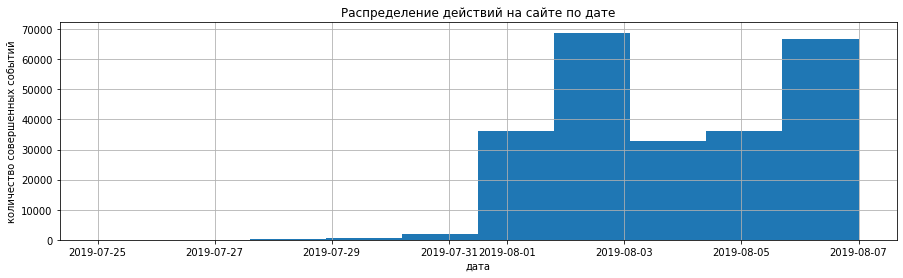

In [14]:
plt.figure(figsize=(15, 4))
df['date_time'].hist()
plt.title('Распределение действий на сайте по дате')
plt.xlabel("дата")
plt.ylabel("количество совершенных событий")
plt.show()

Мы посмотрели на гистограмы и увидели, что часть данных "доехала" к нам из прошлого, поэтому для более точных результатов мы удалим данные до 1 августа 2019 года.

In [15]:
df=df[df['time']>'2019-07-31 23:59:59']

In [16]:
print("Количество событий",df['event'].nunique())
print('Количество пользователей:',df['id'].nunique())
print('Разница количества пользователей', polisov_1-df['id'].nunique())
print('Разница количества совершенных событий:', polisov_2-df['event'].count())

Количество событий 5
Количество пользователей: 7534
Разница количества пользователей 17
Разница количества совершенных событий: 2826


По большому счету у нас ничего не изменилось, после удаления выбивающихся значений. Да, мы потеряли 17 пользователей,но это меньше 1% от всех пользователей, поэтому такие значения мы по праву можем удалить.

In [17]:
group_1=df[df['exp_id']==246][['event', 'id', 'time', 'date_time']]
group_2=df[df['exp_id']==247][['event', 'id', 'time', 'date_time']]
group_3=df[df['exp_id']==248][['event', 'id', 'time', 'date_time']]
print('Количество пользователей в 1 группе:',group_1['id'].nunique())
print('Количество пользователей в 2 группе:', group_2['id'].nunique())
print("Количество пользователей в 3 группе:", group_3['id'].nunique())

Количество пользователей в 1 группе: 2484
Количество пользователей в 2 группе: 2513
Количество пользователей в 3 группе: 2537


### Вывод:

На этом шаге мы отбросили некоторые данные для более точных результатов. Мы удалили 17 пользователя, почти 3000 событий по причине данных "из прошлого ".

<a id='4-bullet'></a>

## Изучение воронки событий.

In [18]:
print('список событий в логе:')
print(df['event'].unique())

список событий в логе:
['Tutorial' 'MainScreenAppear' 'OffersScreenAppear' 'CartScreenAppear'
 'PaymentScreenSuccessful']


In [19]:
print(df['time'].max()-df['time'].min())

6 days 21:07:49


Этот эксперимет проводили в течении 7 дней.

In [20]:
for event in df['event'].unique():
    print('частота для', event,':', int(df[df['event']==event]['id'].count()/7))

частота для Tutorial : 143
частота для MainScreenAppear : 16761
частота для OffersScreenAppear : 6619
частота для CartScreenAppear : 6043
частота для PaymentScreenSuccessful : 4845


* частота для MainScreenAppear : 16761
* частота для OffersScreenAppear : 6619
* частота для CartScreenAppear : 6043
* частота для PaymentScreenSuccessful : 4845
* частота для Tutorial : 143

Выше мы видим список частот(количество в день) для каждого события. 
</div>
</div>

Заметим, что у нас выбивается значение 148, оно значительно меньше всех остальных. А событие 'tutorial'  (руководство) само по себе тоже выбивается из списка событий, потому что оно не входит в цепочку "'MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'" --"главный экран, предложения, ввод карты, оплата" . Поэтому целесообразно удалить это событие из исследования. Далее, мы на других цифрах убедимся, что это нужно сделать.


In [21]:
for event in df['event'].unique():
    print('количество пользователей, совершившие', event,':', df[df['event']==event]['id'].nunique())

количество пользователей, совершившие Tutorial : 840
количество пользователей, совершившие MainScreenAppear : 7419
количество пользователей, совершившие OffersScreenAppear : 4593
количество пользователей, совершившие CartScreenAppear : 3734
количество пользователей, совершившие PaymentScreenSuccessful : 3539


In [22]:
df.groupby('event')['id'].nunique().sort_values()

event
Tutorial                    840
PaymentScreenSuccessful    3539
CartScreenAppear           3734
OffersScreenAppear         4593
MainScreenAppear           7419
Name: id, dtype: int64

Видим, что больше всего пользователей заходили на MainScreenAppear, меньше всего на PaymentScreenSuccessful, несчитая Tutorial. Что объяснимо так как вышеизложенная цепочка предполагает уменьшение число пользователей при переходе к следующему звену. 

In [23]:
(df.groupby('event')['id'].nunique()/df['id'].nunique()*100).sort_values()

event
Tutorial                   11.149456
PaymentScreenSuccessful    46.973719
CartScreenAppear           49.561986
OffersScreenAppear         60.963632
MainScreenAppear           98.473586
Name: id, dtype: float64

Такой же результат мы видим для доли пользователей, которые хоть раз совершали событие.

In [24]:
df=df[df['event']!='Tutorial']

In [25]:
previos=df[df['event']=='MainScreenAppear']['id'].nunique()
for event in df['event'].unique():
    print('Доля для', event, ':' , int(df[df['event']==event]['id'].nunique()/previos*100))
    previos=df[df['event']==event]['id'].nunique()

Доля для MainScreenAppear : 100
Доля для OffersScreenAppear : 61
Доля для CartScreenAppear : 81
Доля для PaymentScreenSuccessful : 94


Выше написано, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). Заметим, что с первого этапа на второй переходит меньше всего пользователей, чем даже с второго на третий. Это интесное наблюдение, потому, что это говорит нам о том, что 40% клиентов заходят на главную страницу сайта и не хотят проходить на страницу предложений. Это больше число чем, число тех, кто посмотрел товары и решил их оплатить. Какой из этого можно сделать вывод: компания хорошо умеет продавать товары, но не может завлечь их на страницу предложений ( клиетам наверняка не устраивает первая страница сайта)

In [26]:
print('доля пользователей, которая доходит от первого события до оплаты:')
print(int(df[df['event']=='PaymentScreenSuccessful']['id'].nunique()/df[df['event']=='MainScreenAppear']['id'].nunique()*100),'%')

доля пользователей, которая доходит от первого события до оплаты:
47 %


### Вывод:

Мы проаналировали события, которые могут произойти с клиентом. Отбросли ненужный. И нашли некоторые закономерности:
* почти половина пользователей доходит до покупки товара.
* 20% пользователей не решаются на покупку товара после просмотра предложений сайта.
* 40% пользователей не переходят на следующую страницу после главной.
</div>

У нас неоднозначные данные, поэтому следуюет сначала поработать над главной страницей сайта, а потом заняться повышением продаж.</div>

<a id='5-bullet'></a>

## A/A/B-тестирование. Изучение результатов эксперимента.

Нулевая гипотеза: Между долями нет значимой разницы.
</div> 

Обратная гипотеза: Между долями есть значимая разница.

In [27]:
def stat(group_1, group_2):
    alpha = .05 # критический уровень статистической значимости
    tmp=df.groupby('exp_id')['id'].nunique().reset_index()
    a_1=tmp.loc[tmp['exp_id']==group_1, 'id']
    b_1=tmp.loc[tmp['exp_id']==group_2, 'id']
    
    group_a=df[df['exp_id']==group_1][['event', 'id', 'time', 'date_time']]
    group_b=df[df['exp_id']==group_2][['event', 'id', 'time', 'date_time']]
    
    
    group_a_2=group_a.groupby('event')['id'].nunique().reset_index()
    group_b_2=group_b.groupby('event')['id'].nunique().reset_index()
    
    for event in group_a['event'].unique():
        a_2=group_a_2.loc[group_a_2['event']==event, 'id']
        b_2=group_b_2.loc[group_b_2['event']==event, 'id']
        #print(a_1.set_index())
        successes = np.array([a_2, b_2])
        trials = np.array([a_1, b_1])
        
# пропорция успехов в первой группе:
        p1 = successes[0]/trials[0]
# пропорция успехов во второй группе:
        p2 = successes[1]/trials[1]
# пропорция успехов в комбинированном датасете:
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
# разница пропорций в датасетах
        difference = p1 - p2
# считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print('p-значение для',event, ":", p_value)
        print('')
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')
        print('')

Мы взяли альфа 0,05 , так как у нас будет много тестов.

In [28]:
df.groupby('exp_id')['id'].nunique().sort_values()

exp_id
246    2483
247    2512
248    2535
Name: id, dtype: int64

In [29]:
group_1.groupby('event')['id'].nunique()

event
CartScreenAppear           1266
MainScreenAppear           2450
OffersScreenAppear         1542
PaymentScreenSuccessful    1200
Tutorial                    278
Name: id, dtype: int64

In [30]:
group_2.groupby('event')['id'].nunique()

event
CartScreenAppear           1238
MainScreenAppear           2476
OffersScreenAppear         1520
PaymentScreenSuccessful    1158
Tutorial                    283
Name: id, dtype: int64

In [31]:
group_3.groupby('event')['id'].nunique()

event
CartScreenAppear           1230
MainScreenAppear           2493
OffersScreenAppear         1531
PaymentScreenSuccessful    1181
Tutorial                    279
Name: id, dtype: int64

z-тест между группами 246 и 247.

In [32]:
stat(246,247)

p-значение для MainScreenAppear : [0.75267034]

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


p-значение для OffersScreenAppear : [0.24786097]

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


p-значение для PaymentScreenSuccessful : [0.11446628]

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


p-значение для CartScreenAppear : [0.22867644]

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




###### По z-тестам мы увидели, что статистической разницы между выборками 246 и 247 нет. Поэтому можем спокойно проводить А\В тест.

z-тест между группами 246 и 248

In [33]:
stat(246,248)

p-значение для MainScreenAppear : [0.33871141]

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


p-значение для OffersScreenAppear : [0.21442477]

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


p-значение для PaymentScreenSuccessful : [0.21693034]

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


p-значение для CartScreenAppear : [0.08067368]

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




##### Видим, что статистической разницы у групп 246 и 248 нет. 

z-тест между группами 248 и 247.

In [34]:
stat(247,248)

p-значение для MainScreenAppear : [0.51949644]

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


p-значение для OffersScreenAppear : [0.93337513]

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


p-значение для PaymentScreenSuccessful : [0.72757187]

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


p-значение для CartScreenAppear : [0.58782846]

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




##### Видим, что статистической разницы у групп 247 и 248 нет. 

z-тест между группами 246+247 и 248

In [35]:

alpha = .05 # критический уровень статистической значимости
tmp=df.groupby('exp_id')['id'].nunique().reset_index()
a=tmp.loc[~(tmp['exp_id']==248), 'id']
b_1=tmp.loc[tmp['exp_id']==248, 'id']
a_1=a[0]+a[1]
group_a=df[~(df['exp_id']==248)][['event', 'id', 'time', 'date_time']]
group_b=df[df['exp_id']==248][['event', 'id', 'time', 'date_time']]
    
    
group_a_2=group_a.groupby('event')['id'].nunique().reset_index()
group_b_2=group_b.groupby('event')['id'].nunique().reset_index()
    
for event in group_a['event'].unique():
    a_2=group_a_2.loc[group_a_2['event']==event, 'id']
    b_2=group_b_2.loc[group_b_2['event']==event, 'id']
        #print(a_1.set_index())
    successes = np.array([a_2, b_2])
    trials = np.array([a_1, b_1])
      
# пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
# пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
# пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
# разница пропорций в датасетах
    difference = p1 - p2
# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение для',event, ":", p_value)
    print('')
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
    print('')
    print('')

p-значение для MainScreenAppear : [0.34866843]

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


p-значение для OffersScreenAppear : [0.44582745]

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


p-значение для PaymentScreenSuccessful : [0.61079187]

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


p-значение для CartScreenAppear : [0.18683559]

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




##### Видим, что статистической разницы у групп 247+246 и 248 нет. 

### Вывод:

Мы доказали, что статистической значимости между группами 246 и 247 нет, поэтому мы в праве провести А\В тест.
</div>

Статистически значимых различий между группами 246 и 248 нет.
</div>

Статистически значимых различий между группами 247 и 248 нет.
</div>

Статистически значимых различий между группами 246+247 и 248 нет.

<a id='6-bullet'></a>

## Общий вывод:

Мы вывели, что при изменении шрифта количество продаж и других переходов на сайте не изменилось. Поэтому мы можем изменить шрифт на сайте без опасений, что клиентам он не понравится, но к сожалению, этот ход не увеличит продажи.
Также мы заметили, что только половина посетителей покупают товар, это не плохой результат, но можно его улучшить. И еще заметили, что приличная часть людей не заходят в раздел предложений после посещения главной страницы. Это важный показатель, так как это может говорить о том, что пользователем не понравилась первая страничка (проблемы с дизайном).